In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import gc
from itertools import islice
%matplotlib inline

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn

# Determining if a Celebrity is Smiling

In this homework, we will download a relatively large data set (1.5GB) of images of celebrities and determine which of them are smiling or not.  In the data set, the images have labeled attributes, one of which being if the person in the photo is smiling.  Thus we are performing a binary classification of an image, but we are doing it on a relatively small feature in the larger image.  

## Getting the CelebA Data Set

This could take a minute!  To enrich our data set, note that we add randomly cropped and flipped versions of the images to the training data set.  This echoes the way we built redundant dictionaries of images in Homework 9.  

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

image_path = './' # just store everything to your local working directory
CelebA_data_path = image_path + '/celeba'
torch.manual_seed(1)

transform_train = transforms.Compose([
    transforms.RandomCrop([178,178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor()
    ])

transform = transforms.Compose([
    transforms.CenterCrop([178,178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor()
    ])

get_smile = lambda attr: attr[31]
dval = False
if not os.path.isdir(CelebA_data_path): # if you've already downloaded and converted the MNIST images, skip
    dval = True    

# Download and convert CelebA images into tensor format. 
celeba_dataset_train = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=dval, 
                                                   transform=transform_train, target_transform=get_smile)
    
celeba_dataset_valid = torchvision.datasets.CelebA(image_path, split='valid', transform=transform, 
                                                       target_type='attr', download=dval, target_transform=get_smile)
    
celeba_dataset_test = torchvision.datasets.CelebA(image_path, split='test', transform=transform, 
                                                       target_type='attr', download=dval, target_transform=get_smile)    

cuda


You should see some faces from different perspectives when you run the next cell. If not, something is wrong.  

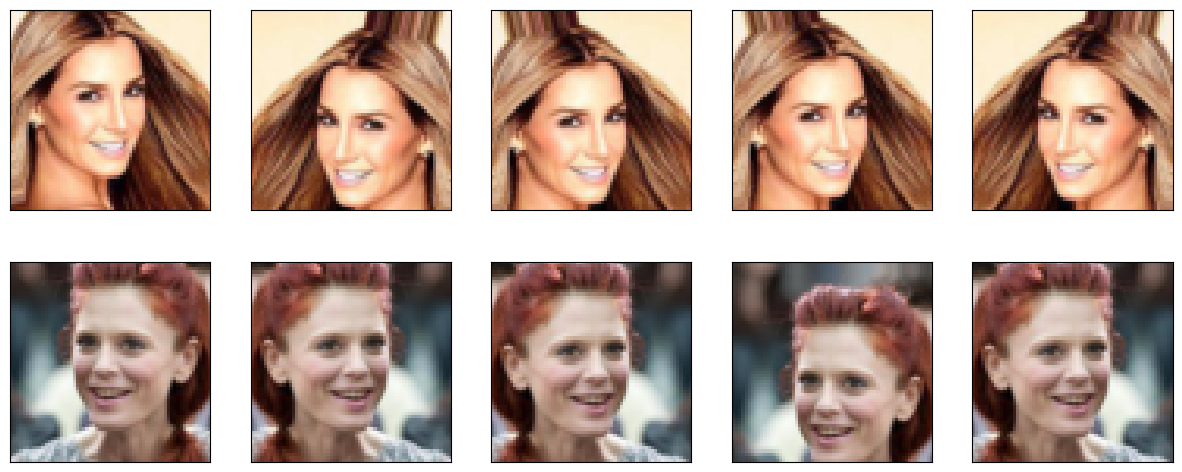

In [4]:
fig = plt.figure(figsize=(15,6))
data_loader = DataLoader(celeba_dataset_train, batch_size=2)
num_perspectives = 5
for jj in range(num_perspectives):
    img_batch, label_batch = next(iter(data_loader))

    img = img_batch[0]
    ax = fig.add_subplot(2,5,jj+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1,2,0))
    
    img = img_batch[1]
    ax = fig.add_subplot(2,5,jj+6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1,2,0))
    

Here we decide on a batch size for running Stochastic Gradient Descent and then get our training data into the proper format for iterating over epochs with a random shuffle into new batches at every iteration.  

In [5]:
batch_size = 32
# we use a smaller version of the training and validation sets to speed up training
celeba_dataset_train = Subset(celeba_dataset_train, torch.arange(16000))
celeba_dataset_valid = Subset(celeba_dataset_valid, torch.arange(1000))

pmem = False
if torch.cuda.is_available():
    pmem = True

train_dl = DataLoader(celeba_dataset_train, batch_size, shuffle=True, pin_memory=pmem)
valid_dl = DataLoader(celeba_dataset_valid, batch_size, shuffle=False, pin_memory=pmem)
test_dl = DataLoader(celeba_dataset_test, batch_size, shuffle=False, pin_memory=pmem)

## Problem: Building the Model

Using the Convolutional_Networks_and_Pooling_Layers notebook as a model, implement the following network architecture.  

In [ ]:
model = nn.Sequential()

# 3 channels in, 32 channels out, kernel size=3, padding=1 2D convolutional layer
# reLU activation function
# max pooling layer with kernel_size = 2
# dropout layer with p=.5 

# 32 channels in, 64 channels out, kernel size=3, padding=1 2D convolutional layer
# reLU activation function
# max pooling layer with kernel_size = 2
# dropout layer with p=.5 

# 64 channels in, 128 channels out, kernel size=3, padding=1 2D convolutional layer
# reLU activation function
# max pooling layer with kernel_size = 2

# 128 channels in, 256 channels out, kernel size=3, padding=1 2D convolutional layer
# reLU activation function
# average pooling layer with kernel_size = 8
# flatten

x = torch.ones((4, 3, 64, 64))
dims = model(x).shape

model.add_module('fc', nn.Linear(dims[1],1))
model.add_module('sigmoid', nn.Sigmoid())
model.to(device)

**Problem**: Explain what the final layer in the above model does and why we can interpret the results as probabilities.  

## Choosing the Loss Function and Optimizer

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

**Problem**: What is the BCELoss and why have we chosen it?  

## Training across Epochs

In [ ]:
num_epochs = 30
loss_history_train = np.zeros(num_epochs)
accuracy_history_train = np.zeros(num_epochs)
loss_history_valid = np.zeros(num_epochs)
accuracy_history_valid = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train() 
    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch.float())
        loss.backward() # perform backpropagation
        optimizer.step() # optimize over the given batch
        optimizer.zero_grad() # zero out the gradient for the next iteration
        is_correct = ( (pred>=.5).float() == y_batch).float()
        loss_history_train[epoch] += loss.item()*y_batch.size(0)
        accuracy_history_train[epoch] += is_correct.sum()

    loss_history_train[epoch] /= len(train_dl.dataset)
    accuracy_history_train[epoch] /= len(train_dl.dataset)
    model.eval() # Note, we need model.train() and model.eval() to manage the dropout layer correctly 
    
    # We now look at validation data as we train to get a sense of how generalizable our model is to test data.

    with torch.no_grad(): # don't optimize at this point, i.e. keep all weights fixed 
        for x_batch, y_batch in valid_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            is_correct = ( (pred>=.5).float() == y_batch).float()
            loss_history_valid[epoch] += loss.item()*y_batch.size(0)
            accuracy_history_valid[epoch] += is_correct.sum()
    loss_history_valid[epoch] /= len(valid_dl.dataset)
    accuracy_history_valid[epoch] /= len(valid_dl.dataset)
    
    print(f"Epoch {epoch} accuracy: {accuracy_history_train[epoch]:.4f} "
          f"val_accuracy: {accuracy_history_valid[epoch]}")
    
del x_batch
del y_batch
del optimizer
gc.collect()
torch.cuda.empty_cache()

In [ ]:
x_arr = np.arange(num_epochs)
fig = plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax.plot(x_arr, loss_history_train, '-o', label='Training Loss')
ax.plot(x_arr, loss_history_valid, '-o', label='Validation Loss')
ax.legend()

ax=fig.add_subplot(1,2,2)
ax.plot(x_arr, accuracy_history_train, '-o', label='Training Accuracy')
ax.plot(x_arr, accuracy_history_valid, '-o', label='Validation Accuracy')
ax.legend();

**Problem**: Describe why you use the `is_correct` condition that you do.

## Analyzing the Test Data

In [ ]:
accuracy_history_test = 0.
with torch.no_grad(): # don't optimize at this point, i.e. keep all weights fixed 
    for x_batch, y_batch in test_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred = model(x_batch)[:, 0]
        is_correct = ( (pred>=.5).float() == y_batch).float()
        accuracy_history_test += is_correct.sum()
    accuracy_history_test /= len(test_dl.dataset)
    
    print(f"Final ccuracy: {accuracy_history_test:.4f} ")

pred = model(x_batch)[:, 0] * 100. # these are the computed probabilities of whether a test image is smiling or not

**Problem**: Using the code above that displayed the images in the training data, and using the fact that `y_batch[jj]==1` if and only if an image is labeled as 'smiling', print out ten test images with a label on each image indicating whether they are actually smiling or not.  Along with this, also print the probability your model finds for whether they are smiling.  